In [35]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [37]:
import scipy.stats as stats

def check_significance(model1_accuracies, model2_accuracies, alpha=0.05, paired=True):
    """
    Checks if the difference in accuracies between two models is statistically significant.

    Args:
        model1_accuracies (list): Accuracies for Model 1 across runs.
        model2_accuracies (list): Accuracies for Model 2 across runs.
        alpha (float): Significance level (default is 0.05).
        paired (bool): Whether to use a paired t-test (default is True). If False, uses an independent t-test.

    Returns:
        bool: True if the difference is statistically significant, False otherwise.
    """
    min_len = min(len(model1_accuracies), len(model2_accuracies))
    if paired:
        # Paired t-test for dependent samples
        _, p_value = stats.ttest_rel(model1_accuracies[:min_len], model2_accuracies[:min_len])
    else:
        # Independent t-test for independent samples
        _, p_value = stats.ttest_ind(model1_accuracies[:min_len], model2_accuracies[:min_len])

    return p_value < alpha

def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


# Color and Marker Definitions

In [38]:
# Plot Hyperparameters
clrs = sns.color_palette("deep", 15)
MAIN_METHOD = "MixCEM Final All Sample"

color_map = {
    "Bayes MLP": "black",
    "Bayes Classifier": "black",
    "MixCEM (ours)": "red",
    "MixCEM (Platt Calibrated)": "red",
    "MixCEM (No Calibration)": "gray",
    "MixCEM (no IntCEM loss)": "black",
    "MixCEM + IntCEM": "orange",
    "MixIntCEM (ours)": "orange",
    "IntCEM": "cyan",
    "Logit Joint CBM": "salmon",
    "Independent CBM": "lightgreen",
    "Sequential CBM": "slateblue",
}

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
    "Sequential CBM",
    "Independent CBM",
    "Logit Joint CBM",
]
for idx, baseline in enumerate(baselines_to_include):
    if baseline not in color_map:
        color_map[baseline] = clrs[idx]

markers = {
    "Joint CBM": '-o',
    "Vanilla CBM": '-o',
    "Sigmoidal Joint CBM": '-o',
    "Logit Joint CBM": '-v',
    "Sequential CBM": '-^',
    "Independent CBM": '-2',
    "Hybrid-CBM": '-v',
    "Hybrid CBM": '-v',
    "CEM": '-^',
    "IntCEM": '-x',
    "ProbCBM": '-s',
    "Posthoc CBM": '-p',
    "P-CBM": '-p',
    "Posthoc Hybrid CBM": '-1',
    "Hybrid Posthoc CBM": '-1',
    "Hybrid P-CBM": '-1',
    "MixCEM (ours)": '--*',
    "MixCEM (Platt Calibrated)": '--*',
    "MixCEM (No Calibration)": ':*',
    "MixCEM (no IntCEM loss)": ":*",
    "MixCEM + IntCEM": ":*",
    "MixIntCEM (ours)": ":*",
    "Bayes MLP": ":.",
    "Bayes Classifier": ":.",
}

max_limit = 10

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'

rename_map = {
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
    MAIN_METHOD: "MixCEM (ours)",
    MAIN_METHOD + " No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final All No Sample": "MixCEM (No test-time sampling)",
    "MixCEM Final Sample No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final Sample": "MixCEM (Platt Calibrated)",
    "MixCEM Final": "MixCEM (ours)",
    "MixCEM Final All": "MixCEM (ours)",
    "Entropy CMCMixIntCEM No Calibration": "MixIntCEM (No Calibration)",
    "Entropy CMCMixCEM No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final No Calibration": "MixCEM (No Calibration)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Classifier",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
used_rename_map = rename_map
show_variance = True
ood_suffix = 'OOD_sap_0.1_'

# Selected Models

In [43]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='CUB',
        n_concepts=112,
        n_groups=28,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='CUB-Incomplete',
        # rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
        n_concepts=22,
        n_groups=7,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='AwA2',
        n_concepts=85,
        n_groups=28,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='AwA2-Incomplete',
        n_concepts=9,
        n_groups=6,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cifar10/',
        name='CIFAR10',
        n_concepts=143,
        n_groups=143,
        intervention_freq=11,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='CelebA',
        n_concepts=9,
        n_groups=6,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_complete/',
        name='TravelingBirds',
        n_concepts=112,
        n_groups=28,
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/travelingbirds_incomplete/',
        name='TravelingBirds-Incomplete',
        n_concepts=22,
        n_groups=7,
    ),
]
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
    res['selected_models'] = joblib.load(os.path.join(res['path'], f'selected_models_{select_metric}.joblib'))

baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    MAIN_METHOD,
]
for dataset_results in results_to_include:
    print("****" * 10, f"{dataset_results['name']}", "****" * 10)
    for label in baselines_to_include:
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        model_name = dataset_results['selected_models'].get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        print(f"\tFor {label} we selected:", model_name)

**************************************** CUB ****************************************
	For DNN we selected: DNN_extra_dims_200
	For Joint CBM we selected: CBM_Sigmoid_Baseline_cwl_10
	For Hybrid-CBM we selected: Hybrid-CBM_Sigmoid_extra_dims_50_Baseline_cwl_5
	For Sigmoidal CEM we selected: Sigmoidal CEM (Baseline)
	For ProbCBM we selected: ProbCBM_cwl_class_hidden_dim_128_hidden_dim_32_n_samples_inference_50_max_concept_epochs_70_max_task_epochs_75
	For Posthoc CBM we selected: PCBM_reg_1e-06_l1_0.99_penalty_1
	For Posthoc Hybrid CBM we selected: HybridPCBM_reg_1e-06_l1_0.99_penalty_1
	For CEM we selected: CEM_Baseline_cwl_1
	For IntCEM we selected: IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.5_Baseline_cwl_1
	For MixCEM Final All Sample we selected: MixCEM_Final_t_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.5_emb_16_True_tip_0.25_itd_1_iw_0_cwl_1
**************************************** CUB-Incomplete **************************************

# Abstract Figures

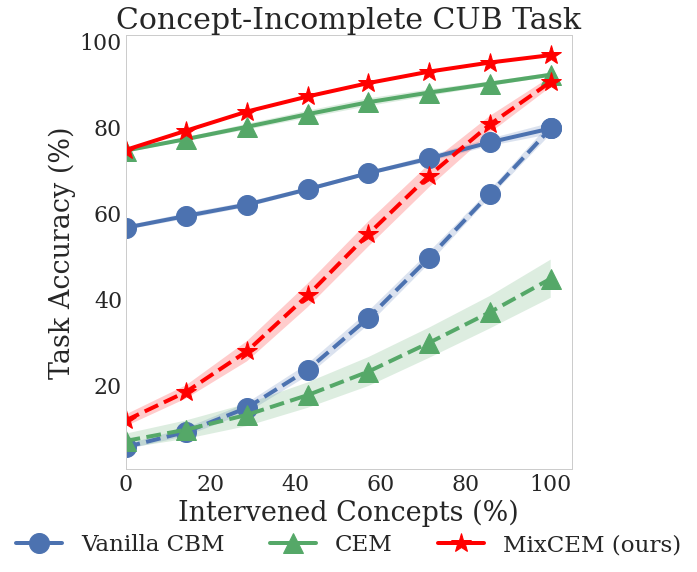

In [44]:
rc('text', usetex=False) # For quality, let's temporarily disable this
used_baselines_to_include = [
    "Joint CBM",
    "CEM",
    MAIN_METHOD,
    # "DNN",
]

fig, ax = plt.subplots(figsize=(8, 8))

used_results_to_include = [
    x for x in results_to_include
    if "CUB-Incomplete" == x['name']
][0]

results = used_results_to_include['results']
selected_models = used_results_to_include['selected_models']
for row, (mode_name, mode_key) in enumerate([
    ("Baseline", " (Baseline)"),
    ("Baseline OOD", " (Baseline)"),
]):
    for idx, label in enumerate(used_baselines_to_include):
        label = used_results_to_include.get('remap', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{'OOD_sap_0.1_' if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", used_results_to_include['name'], "as we could not find any results...")
            continue
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        if "DNN" in label:
            if "OOD" in mode_name:
                continue
            color = 'black'
            linestyle = "dashdot"
            color = 'black'
            ax.plot(
                list(xticks) + [105],
                [means[0] for _ in xticks] + [means[0]],
                # '.',
                color=color,
                label=label + " (Black Box)",
                linestyle=linestyle,
                markersize=20,
                linewidth=3,
                alpha=0.5,
            )
            continue

        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        if "OOD" in mode_name:
            # label += " (OOD Sample)"
            linestyle = '--'
        else:
            # label += " (ID Sample)"
            linestyle = '-'
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=20,
            linewidth=4,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    ax.set_ylabel("Task Accuracy (%)", fontsize=15+15 + -3)
    ax.set_xlabel("Intervened Concepts (%)", fontsize=15+15 + -3)
    ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.set_title('Concept-Incomplete CUB Task', fontsize=30)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+8,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.1),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/abstract_interventions{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/abstract_interventions{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


# Latex Tables

### Table 1: Task and concept fidelities

In [45]:
from texttable import Texttable
import latextable
from collections import defaultdict

used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

significance_check_method = "test" # "test" or "confidence" or "max"
latex_table = Texttable()
baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    MAIN_METHOD,
]
num_stds = 2
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [r'\texttt{' + x['name'] +'}' for x in used_results_to_include]
rows = []
metrics_to_include = [('test_acc_y', 'mediumred'), ('test_auc_c', 'mediumblue')]
col_results =  [defaultdict(list) for _ in metrics_to_include]
best_col_results = [defaultdict(lambda: (-float("inf"), None, None)) for _ in metrics_to_include]

for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(used_results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_vals = []
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            ))
            if len(metric_val) == 0:
                raise ValueError(
                    f'We could not find values for {dataset_results["name"]}'
                )
            used_name = rename_map.get(label, label)
            if len(new_row) == 0:
                new_row.append(used_name)
            mean = np.mean(metric_val, axis=0) * 100
            std = np.std(metric_val, axis=0) * 100
            if mean > best_col_results[metric_idx][col][0]:
                best_col_results[metric_idx][col] = (mean, std, metric_val)
            col_results[metric_idx][col].append((mean, std, metric_val))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(used_results_to_include):
        entry = '$'
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            mean, std, vals = col_results[metric_idx][col][idx]
            if metric_idx:
                entry += " \; / \;"
            if "DNN" in label and metric == "test_auc_c":
                # Then this is not applicable
                entry += " \\textcolor{gray}{\\text{N/A \; \; \; \; \;}} "
            else:
                bolden = False
                if significance_check_method == "confidence" and (
                    mean + num_stds * std >= (best_col_results[metric_idx][col][0] - num_stds * best_col_results[metric_idx][col][1])
                ):
                    bolden = True
                elif significance_check_method == "test" and (
                    not check_significance(best_col_results[metric_idx][col][2], vals)
                ):
                    bolden = True
                elif significance_check_method == "max" and (
                    best_col_results[metric_idx][col][0] == mean
                ):
                    bolden = True
                if bolden:
                    entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
        new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task Accuracy results"
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


-- Example 1: Basic --
Texttable Output:
+-----------+-----------+----------+----------+----------+----------+----------+
|  Method   | \texttt{C | \texttt{ | \texttt{ | \texttt{ | \texttt{ | \texttt{ |
|           |    UB}    | CUB-Inco |  AwA2}   | AwA2-Inc | CIFAR10} | CelebA}  |
|           |           | mplete}  |          | omplete} |          |          |
+===========+===========+==========+==========+==========+==========+==========+
|           |           | $ \textc | $ \textc | $ \textc | $ \textc | $ \textc |
|           | $ \textco | olor{med | olor{med | olor{med | olor{med | olor{med |
|           | lor{mediu | iumred}{ | iumred}{ | iumred}{ | iumred}{ | iumred}{ |
|           | mred}{71. | 71.42_{\ | 89.20_{\ | \underli | \underli | 25.39_{\ |
|           |  18_{\pm  |    pm    |    pm    | ne{89.33 | ne{80.79 |    pm    |
|           | 0.67}} \; |  0.30}}  |  0.26}}  |  _{\pm   |  _{\pm   |  0.49}}  |
|    DNN    | / \; \tex | \; / \;  | \; / \;  | 0.22}}}  | 0.22}}}  

# Combined Results

## All Non-OOD Results

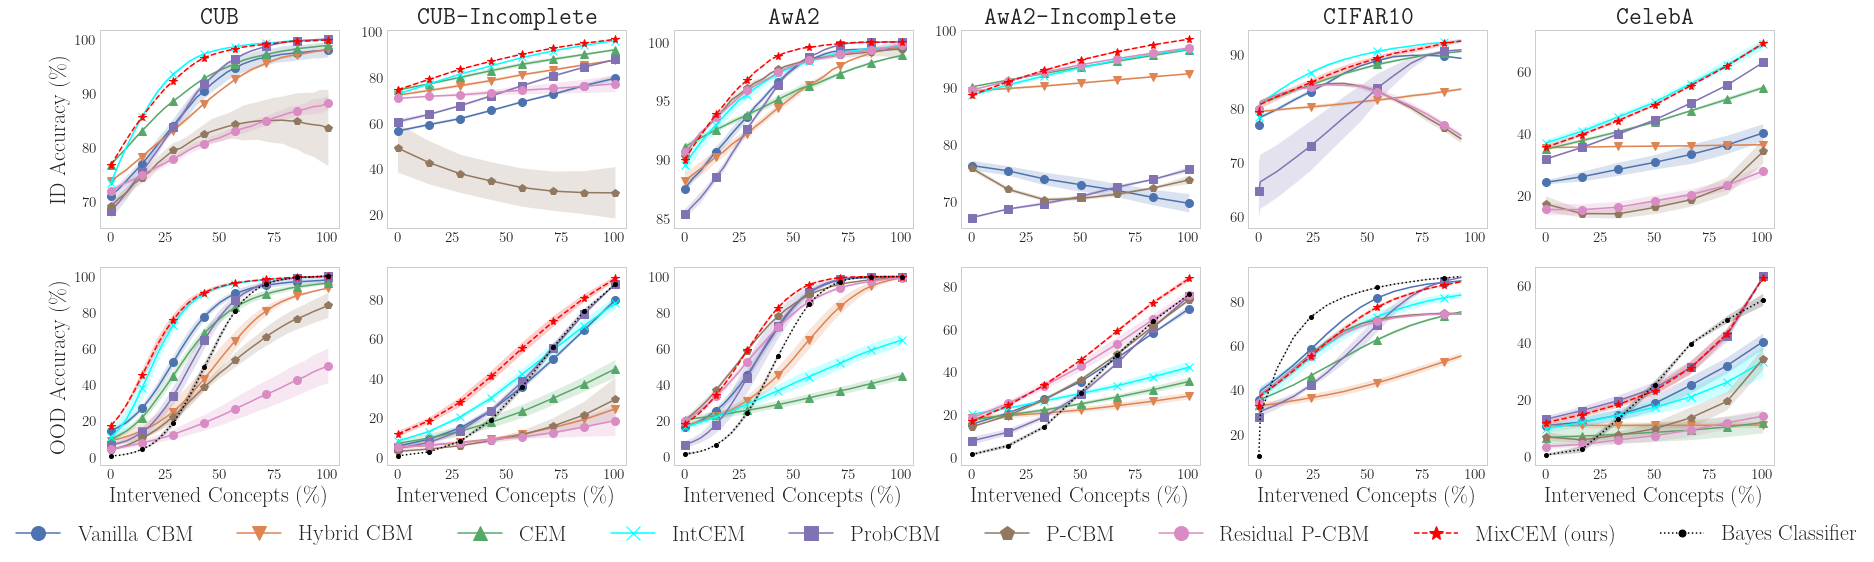

In [8]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    MAIN_METHOD,
    "Bayes MLP",
]
std_scale = 1

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(5*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = dataset_results['n_concepts']
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - std_scale * stds,
                    means + std_scale * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=22)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=22)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=22,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/paper/all_non_ood_results_together_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/all_non_ood_results_together_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_together_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Different Variations of CBMs

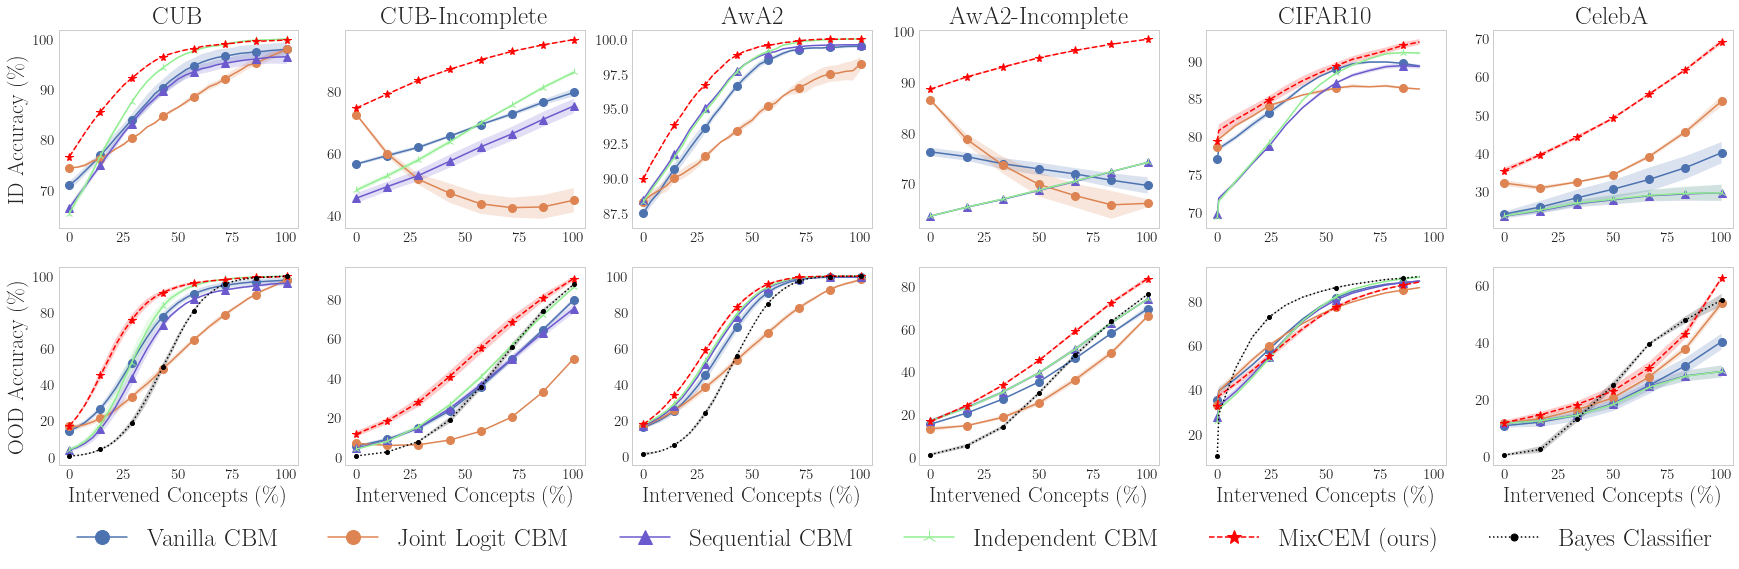

In [9]:
used_results_to_include = [
    x for x in used_results_to_include
    if "TravelingBirds" not in x['name']
]

### Different Variations of CBMs
used_baselines_to_include = [
    "Joint CBM",
    "Joint Logit CBM",
    "Sequential CBM",
    "Independent CBM",
    MAIN_METHOD,
    "Bayes MLP",
]
variance_use = 1

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(5*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - variance_use * stds,
                    means + variance_use * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=22)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=22)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=25,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/cbm_variations_results_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/cbm_variations_results_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/cbm_variations_results_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/cbm_variations_results_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Comparison Between the InCEM and non-IntCEM versions of MixCEM

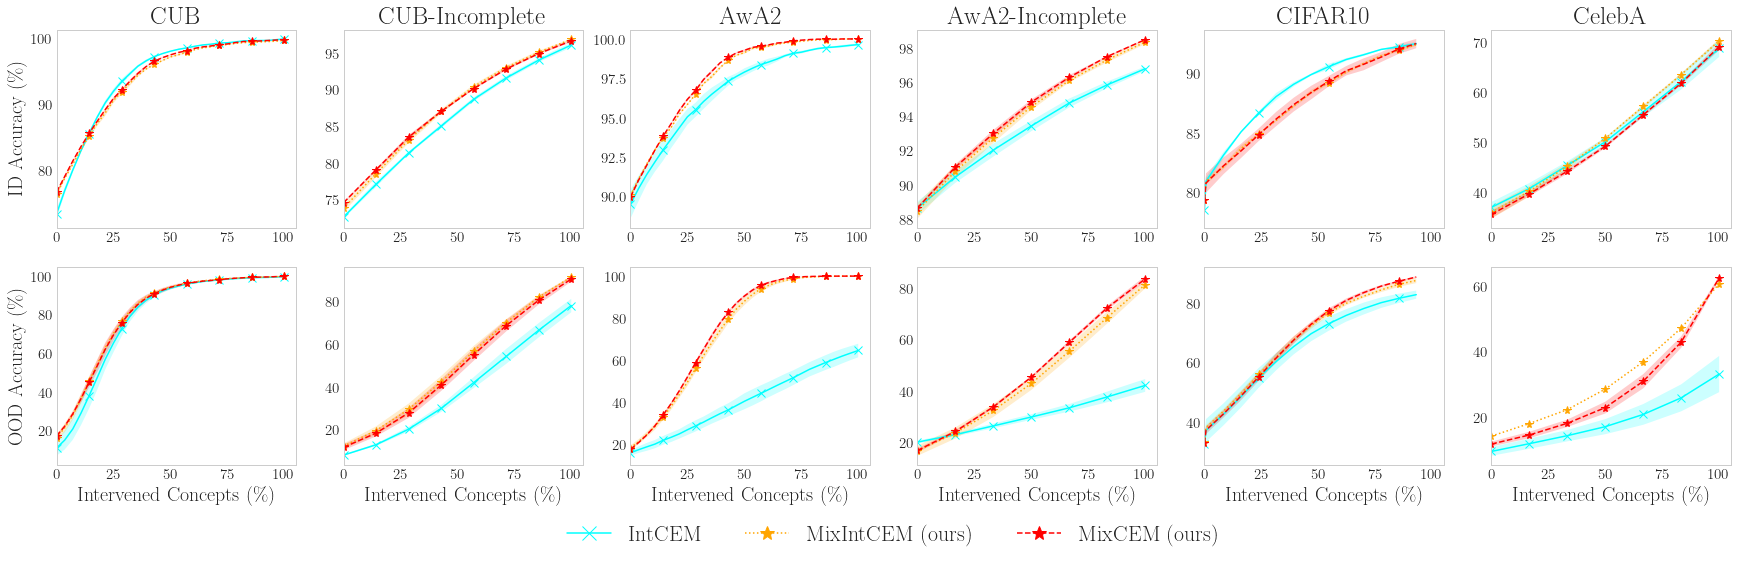

In [129]:
used_results_to_include = [
    x for x in used_results_to_include
    if "TravelingBirds" not in x['name']
]

used_baselines_to_include = [
    "IntCEM",
    "Entropy CMCMixIntCEM",
    MAIN_METHOD,
]

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(5*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            if ("Bayes" in label) and ("OOD" not in mode_name):
                continue
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(0, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=20)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=20)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=22,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/all_non_ood_results_mixcem_vs_mixintcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/all_non_ood_results_mixcem_vs_mixintcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Same plots without any calibration

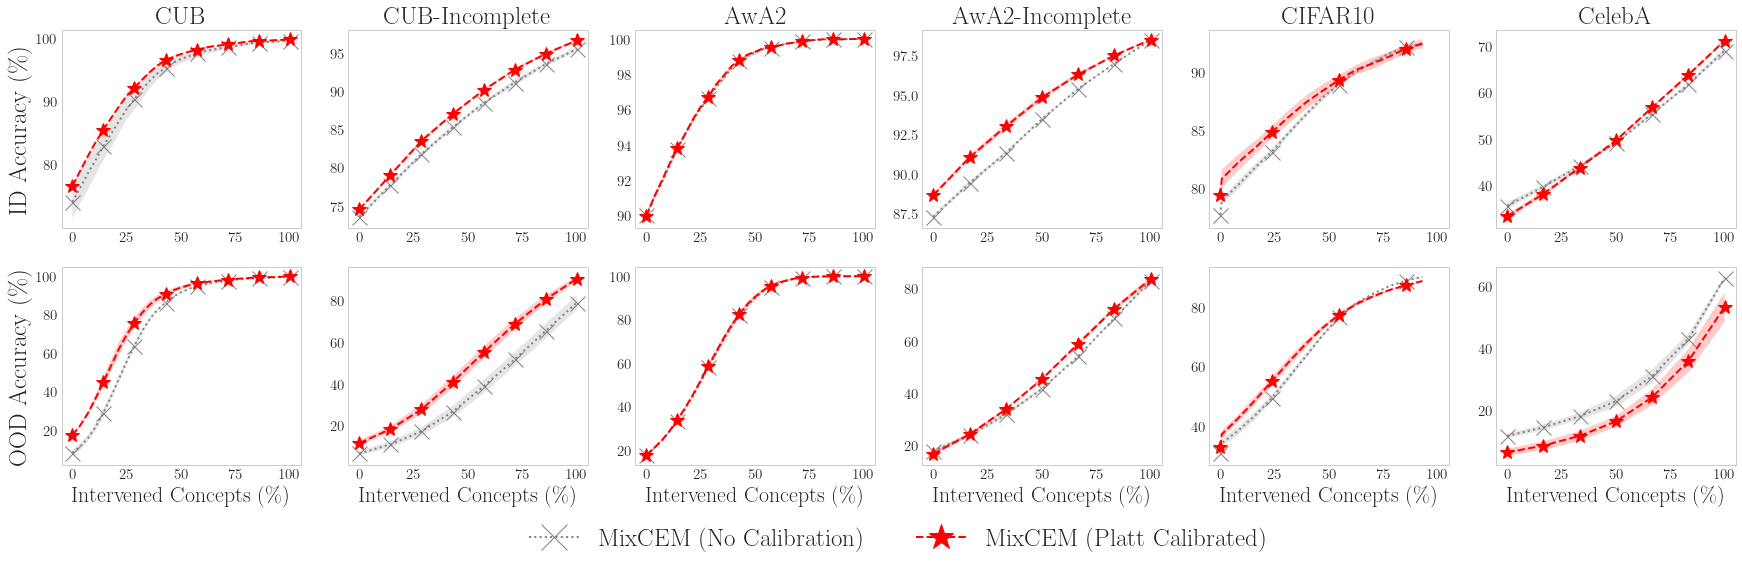

In [10]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]
used_baselines_to_include = [
    MAIN_METHOD.replace(" All", "") + " No Calibration",
    MAIN_METHOD.replace(" All", ""),
    # "Bayes MLP",
]

variance_use = 1

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(5*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']

    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if "No Calibration" in label:
                marker = marker.replace('*', 'x')
                
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            label = label.replace("ours", "Platt Calibrated")
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=15,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - variance_use * stds,
                    means + variance_use * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        handles, labels = ax.get_legend_handles_labels()
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=25)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=25)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=25,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/ablation_cal_vs_cal_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/ablation_cal_vs_cal_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_cal_vs_cal_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_cal_vs_cal_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

## Test-time Sampling vs no Sampling Results

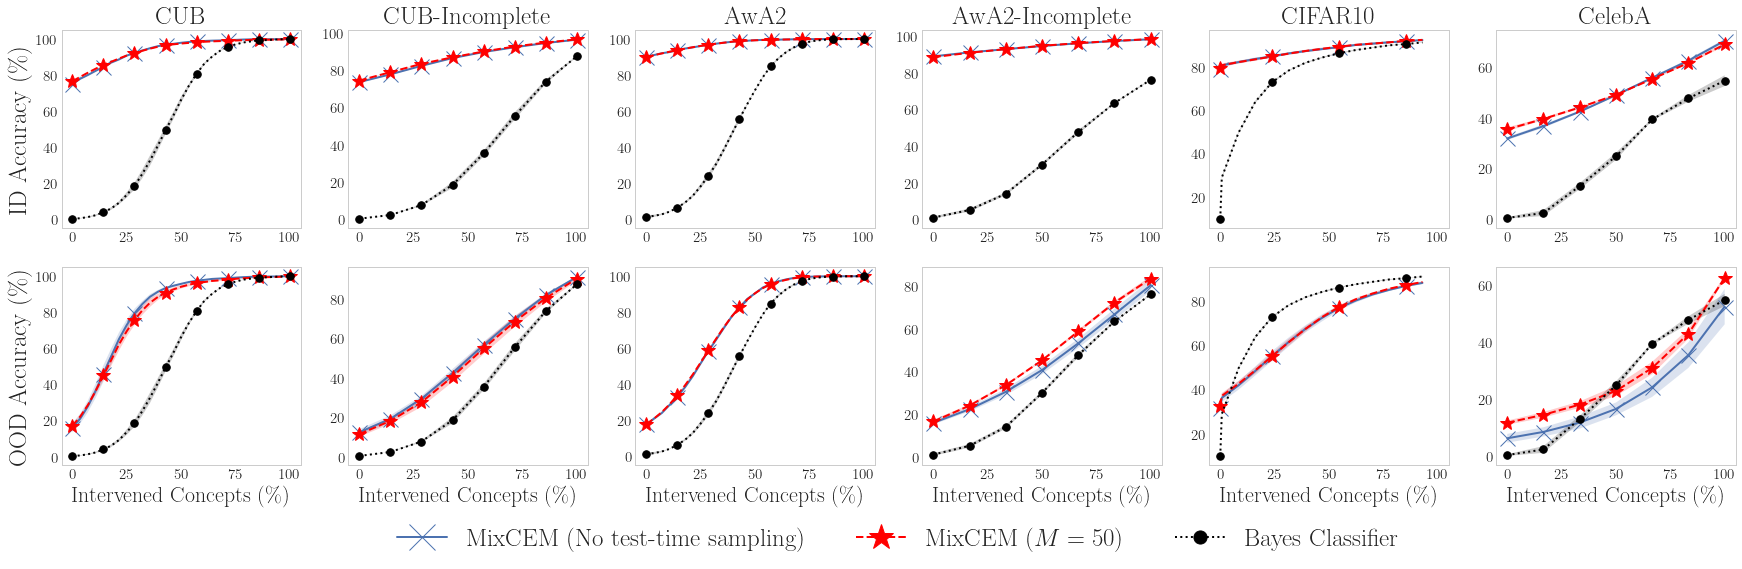

In [11]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]
used_baselines_to_include = [
    "MixCEM Final All No Sample",
    MAIN_METHOD,
    "Bayes MLP",
]

variance_use = 1

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(5*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']

    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if "Calibration" in label:
                marker = marker.replace('*', 'x')
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            label = label.replace("ours", "$M = 50$")
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=15,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - variance_use * stds,
                    means + variance_use * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        handles, labels = ax.get_legend_handles_labels()
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=25)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=25)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=25,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/ablation_sample_vs_no_sample{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/ablation_sample_vs_no_sample{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_sample_vs_no_sample{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_sample_vs_no_sample{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Check if the task accuracy should be included in the calibration loss

Skipping MixCEM No Task Cal All Sample (Baseline) for CUB as we could not find any results...
Skipping Bayes Classifier (Baseline) for CUB as we could not find any results...
Skipping MixCEM No Task Cal All Sample (Baseline) for CUB as we could not find any results...
Skipping Bayes Classifier (Baseline) for CUB as we could not find any results...
Skipping Bayes Classifier (Baseline) for CUB-Incomplete as we could not find any results...
Skipping Bayes Classifier (Baseline) for CUB-Incomplete as we could not find any results...
Skipping MixCEM No Task Cal All Sample (Baseline) for AwA2 as we could not find any results...
Skipping Bayes Classifier (Baseline) for AwA2 as we could not find any results...
Skipping MixCEM No Task Cal All Sample (Baseline) for AwA2 as we could not find any results...
Skipping Bayes Classifier (Baseline) for AwA2 as we could not find any results...
Skipping Bayes Classifier (Baseline) for AwA2-Incomplete as we could not find any results...
Skipping Bayes Clas

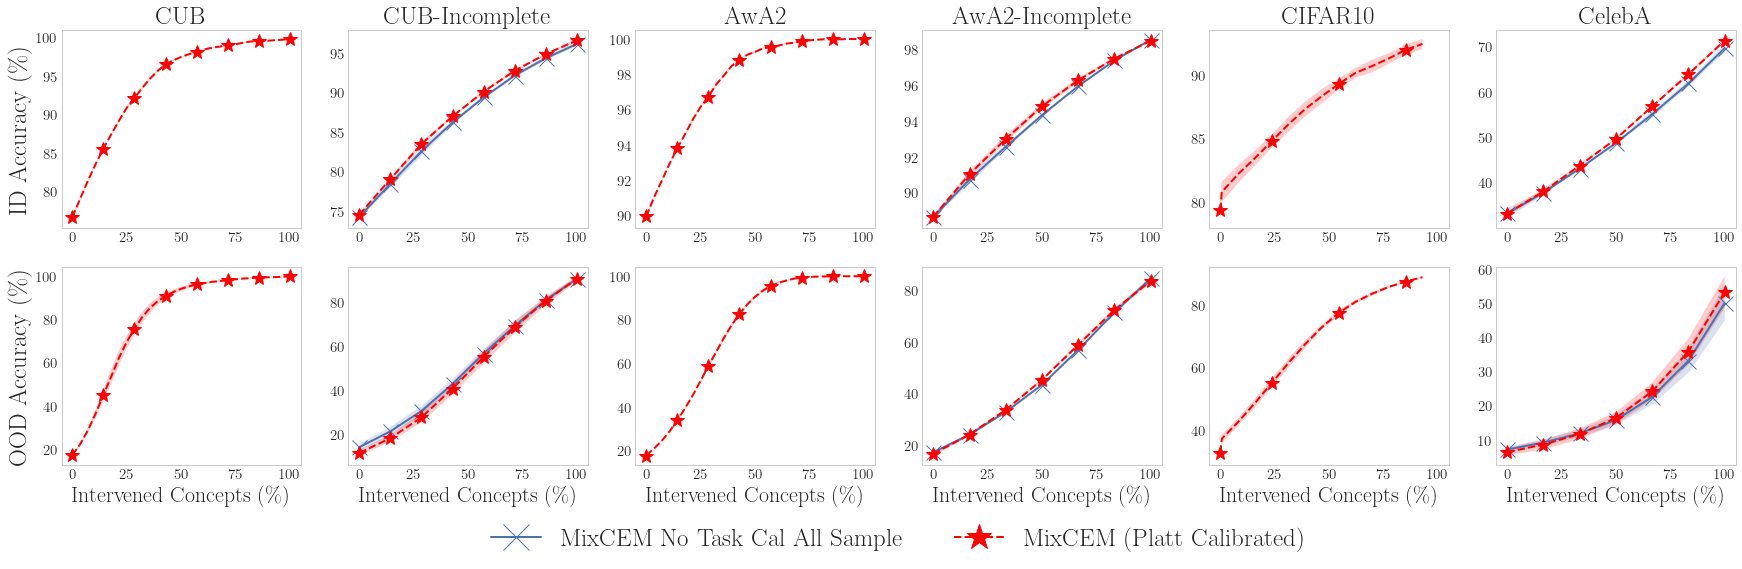

In [12]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]
used_baselines_to_include = [
    "MixCEM No Task Cal All Sample",
    # MAIN_METHOD,
    "MixCEM Final Sample",
    "Bayes Classifier",
]

variance_use = 1

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(5*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']

    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if "Calibration" in label:
                marker = marker.replace('*', 'x')
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            label = label.replace("ours", "$M = 50$")
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=15,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - variance_use * stds,
                    means + variance_use * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        handles, labels = ax.get_legend_handles_labels()
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=25)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=25)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=25,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/ablation_no_task_cal{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/ablation_no_task_cal{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_no_task_cal{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_no_task_cal{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Finally, check if RandInt is needed at all

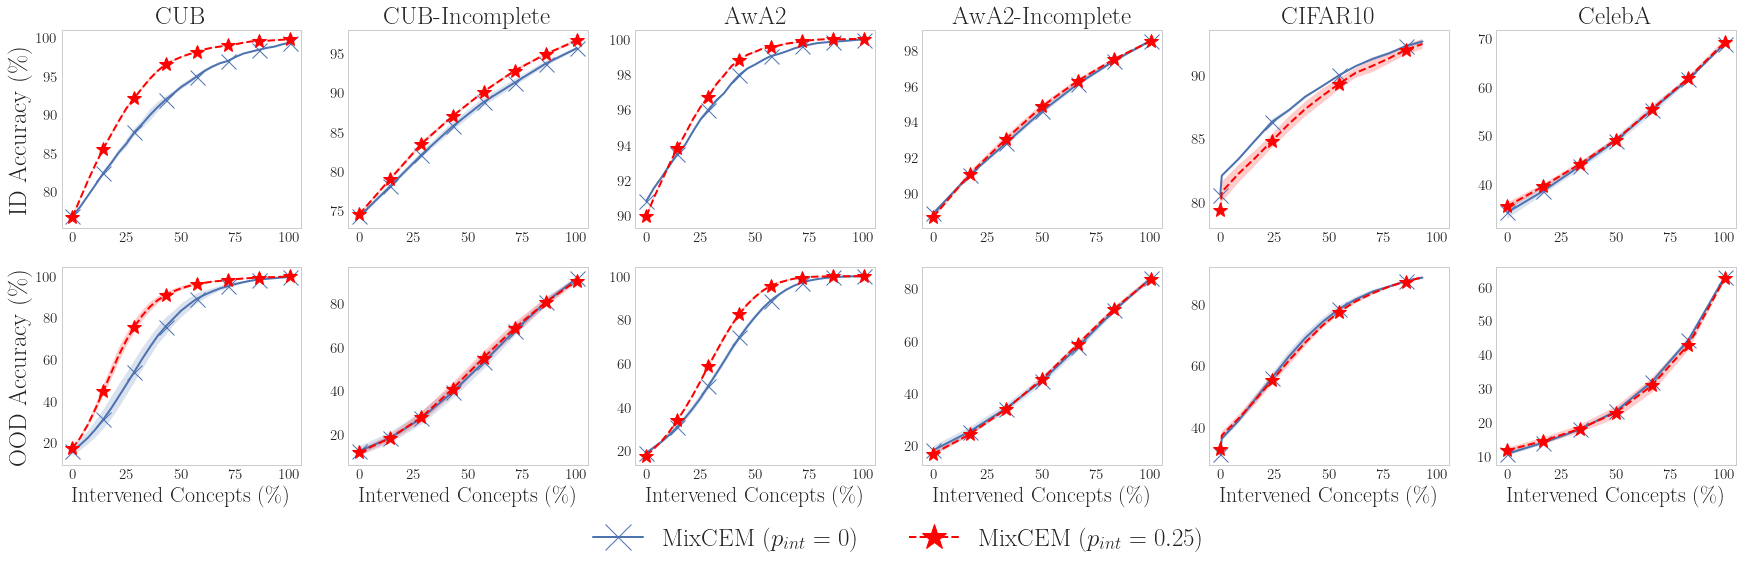

In [13]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]
used_baselines_to_include = [
    "MixCEM No RandInt Sample",
    MAIN_METHOD,
    # "MixCEM Final Sample",
    # "Bayes MLP",
]

variance_use = 1

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(5*len(used_results_to_include), 8), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']

    selected_models = dataset_results['selected_models']
    for row, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if "Calibration" in label:
                marker = marker.replace('*', 'x')
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            label = label.replace("ours", "$p_{int} = 0.25$")
            label = label.replace("No RandInt Sample", "($p_{int} = 0$)")
            
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=15,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=15,
                    linewidth=2,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - variance_use * stds,
                    means + variance_use * stds,
                    alpha=0.2,
                    facecolor=color,
                )
        handles, labels = ax.get_legend_handles_labels()
        ax.set_xlim(-5, 105)
        if col == 0:
            if row == 0:
                ax.set_ylabel("ID Accuracy (\%)", fontsize=25)
            else:
                ax.set_ylabel("OOD Accuracy (\%)", fontsize=25)

        if row == (axs.shape[0] - 1):
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        if row == 0:
            ax.set_title(dataset_results['name'], fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=25,
    loc='upper center',
    bbox_to_anchor=(-2.5,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/ablation_randint_vs_no_randint{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/ablation_randint_vs_no_randint{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_randint_vs_no_randint{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/ablation_randint_vs_no_randint{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

## Noise Ablation (without IntCEM's Losses)

Skipping CEM_emb_size_32_cwl_10 for CUB-Incomplete as we could not find any results...
Skipping IntCEM_intervention_weight_5_intervention_task_discount_1.5_emb_size_32_cwl_1 for CUB-Incomplete as we could not find any results...
Skipping Hybrid Posthoc CBM (Baseline) for CUB-Incomplete as we could not find any results...
Skipping MixCEM_Final_derp_t_1_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.9_emb_16_True_tip_0.25_itd_1_iw_0_cwl_10 for CUB-Incomplete as we could not find any results...
Skipping CEM_emb_size_32_cwl_10 for CUB-Incomplete as we could not find any results...
Skipping IntCEM_intervention_weight_5_intervention_task_discount_1.5_emb_size_32_cwl_1 for CUB-Incomplete as we could not find any results...
Skipping Hybrid Posthoc CBM (Baseline) for CUB-Incomplete as we could not find any results...
Skipping MixCEM_Final_derp_t_1_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_0_g_ood_0.9_emb_16_True_tip_0.25_itd_1_iw_0_cwl_10 for CUB-Incomplete as we could not find

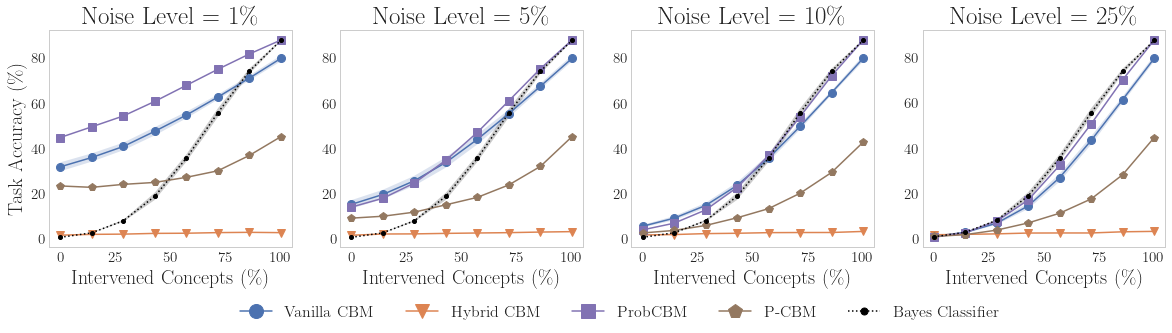

In [134]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB-Incomplete" == x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
    "Bayes MLP",
]

noise_levels = [
    0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(5*len(noise_levels), 4))
results = dataset_results['results']

for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

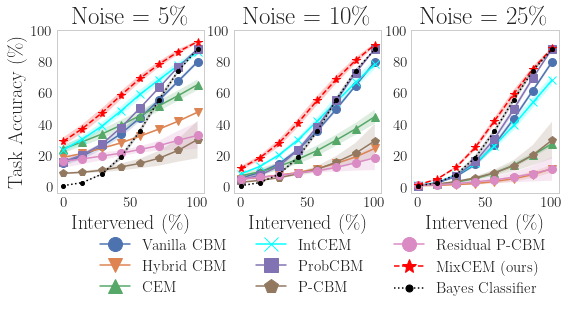

In [135]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB-Incomplete" == x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
    "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']

selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise = {int(noise_level*100)}\%", fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles,
    labels,
    fontsize=15,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

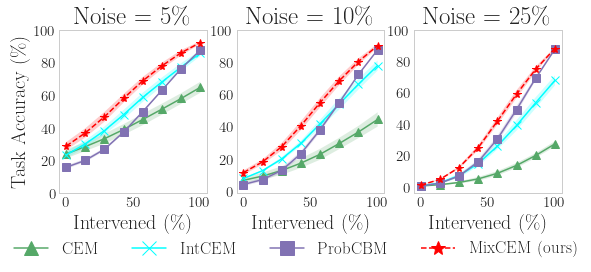

In [14]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB-Incomplete" == x['name']
]
used_baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    MAIN_METHOD,
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']

selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise = {int(noise_level*100)}\%", fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles,
    labels,
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.8,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_best_performing{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_best_performing{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/noise_ablation_small_true_mixcem_best_performing{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/noise_ablation_small_true_mixcem_best_performing{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

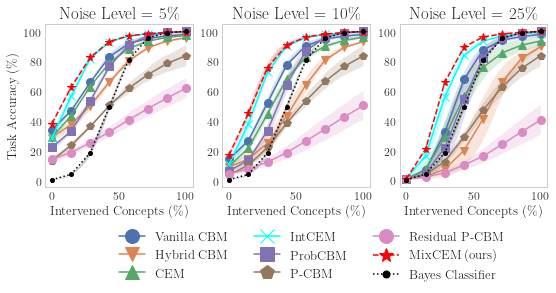

In [38]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB" == x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    MAIN_METHOD,
    "Bayes MLP",
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']

selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

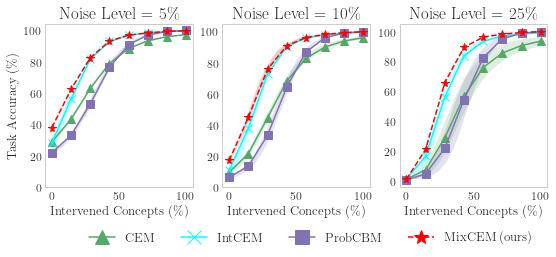

In [39]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB" == x['name']
]
used_baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    MAIN_METHOD,
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']

selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=13)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_yticks(range(0, 101, 20))
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=13,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp_best_performing{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_small_true_mixcem_cub_comp_best_performing{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

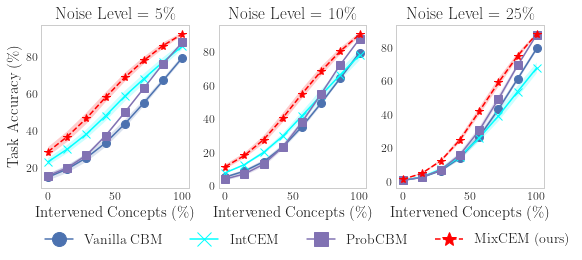

In [40]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB-Incomplete" == x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "IntCEM",
    "ProbCBM",
    MAIN_METHOD,
]

noise_levels = [
    # 0.01,
    0.05,
    0.1,
    0.25,
    # 0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']

selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=15)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.6,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_smaller_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_smaller_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

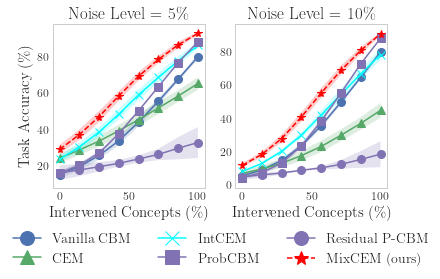

In [41]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB-Incomplete" == x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
]

noise_levels = [
    0.05,
    0.1,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(3*len(noise_levels), 3))
results = dataset_results['results']

selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=15)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=20-3)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=3,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_tiny_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_tiny_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

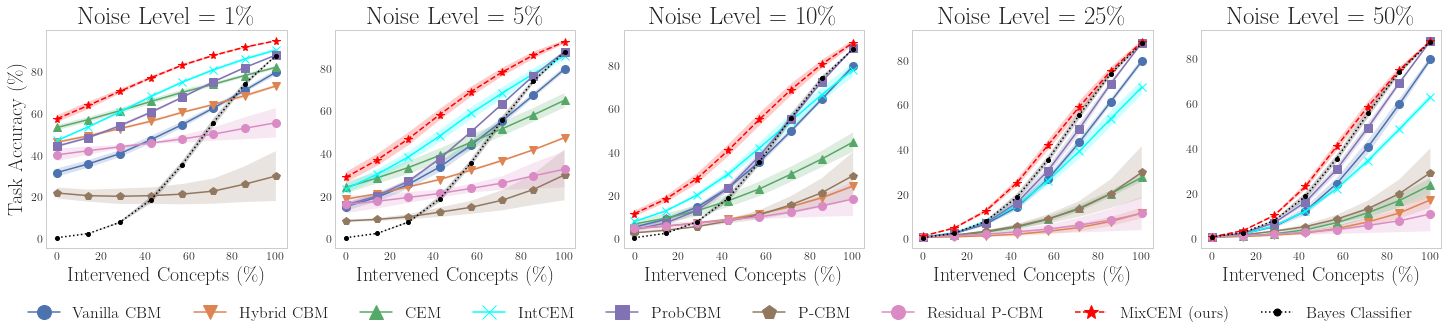

In [42]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB-Incomplete" == x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
    "Bayes MLP",
]
noise_levels = [
    0.01,
    0.05,
    0.1,
    0.25,
    0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]

dataset_results = used_results_to_include[0]

fig, axs = plt.subplots(1, len(noise_levels), figsize=(5*len(noise_levels), 4))
results = dataset_results['results']

selected_models = dataset_results['selected_models']
for col, noise_level in enumerate(noise_levels):
    ood_suffix = f'OOD_sap_{noise_level}_'
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline OOD"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.grid(False)
    ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=25)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-2,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_complete_cub_incomp_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_complete_cub_incomp_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

### Complete Noise Ablation for both CUB and CUB-Incomplete

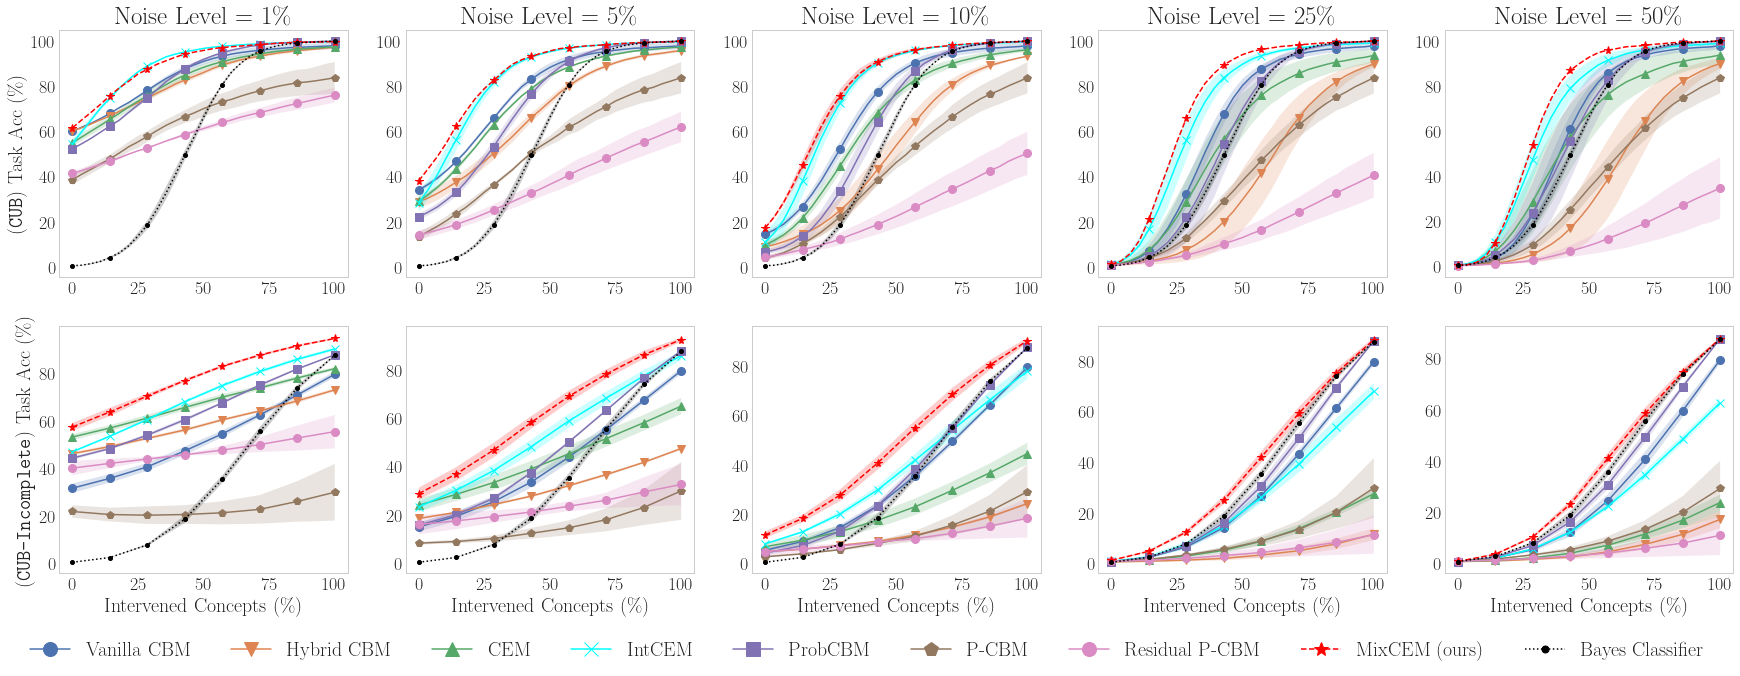

In [15]:
used_results_to_include = [
    x for x in results_to_include
    if "CUB" in x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    # "Hybrid Posthoc CBM",
    "Posthoc Hybrid CBM",
    MAIN_METHOD,
    "Bayes MLP",
]
noise_levels = [
    0.01,
    0.05,
    0.1,
    0.25,
    0.5,
    # 0.75,
    # 0.9,
    # 0.99,
]
fig, axs = plt.subplots(len(used_results_to_include), len(noise_levels), figsize=(6*len(noise_levels), 10))
for row, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    for col, noise_level in enumerate(noise_levels):
        ood_suffix = f'OOD_sap_{noise_level}_'
        ax = axs[row, col]
        for idx, label in enumerate(used_baselines_to_include):
            mode_key = " (Baseline)"
            mode_name = "Baseline OOD"
            label = dataset_results.get('rename', {}).get(label, label)
            model_name = selected_models.get(
                label + mode_key,
                label + mode_key,
            )
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
                continue
            label = used_rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(label, clrs[idx])
            marker = markers.get(label, "-x" if "Mix" in label else "-o")
            if dataset_results.get('intervention_freq', 1) != 1:
                freq = dataset_results.get('intervention_freq', 1)
                total_concepts = (len(means) - 1) * freq
                xticks = (
                    [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
                )
            else:
                xticks = (
                    [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
                )
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )
            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - stds,
                    means + stds,
                    alpha=0.2,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            ax.set_ylabel(r'(\texttt{' + dataset_results['name'] + r'}) ' + "Task Acc (\%)", fontsize=20)
        if row == len(used_results_to_include) - 1:
            ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.grid(False)
        if row == 0:
            ax.set_title(f"Noise Level = {int(noise_level*100)}\%", fontsize=25)
        handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(-2,-0.2),
    ncol=9,
    markerscale=1.75,
)
plt.savefig(f"../figures/noise_ablation_complete_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/noise_ablation_complete_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/noise_ablation_complete_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/noise_ablation_complete_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

## Spurious Correlations Plots Without IntCEM's Losses

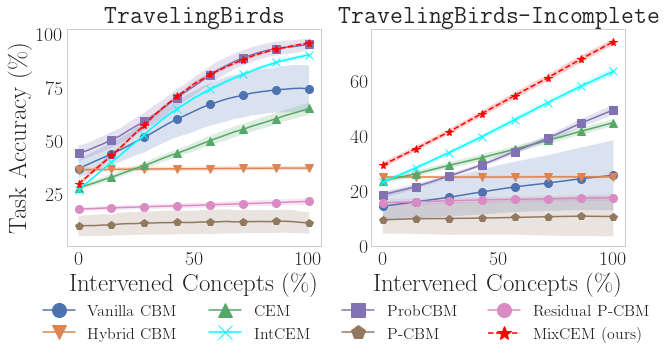

In [44]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(5*len(used_results_to_include), 4))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=25)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)
plt.savefig(f"../figures/spurious_results_real_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_real_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

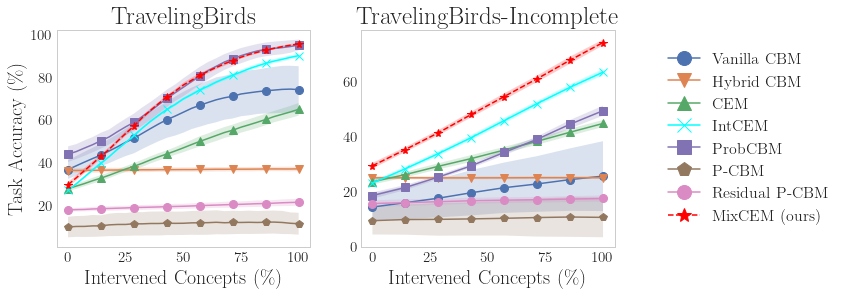

In [45]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(5*len(used_results_to_include), 4), squeeze=False)
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[0, col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_title(dataset_results['name'], fontsize=25)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='center right',
    bbox_to_anchor=(1.9,0.5),
    ncol=1,
    markerscale=1.75,
)
plt.savefig(f"../figures/spurious_results_incomplete_only_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_incomplete_only_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

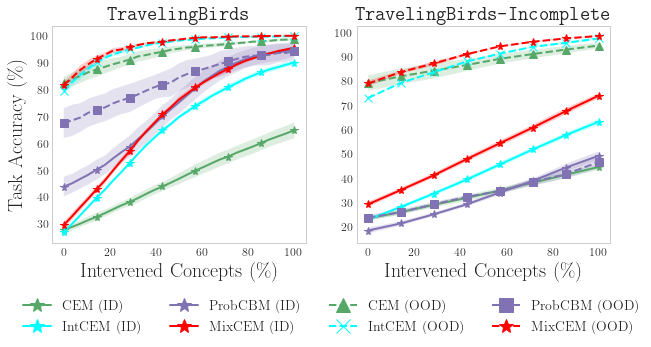

In [46]:
used_results_to_include = [
    x for x in used_results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    MAIN_METHOD,
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(5*len(used_results_to_include), 4))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(r'\texttt{' + dataset_results['name'] +'}', fontsize=20)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

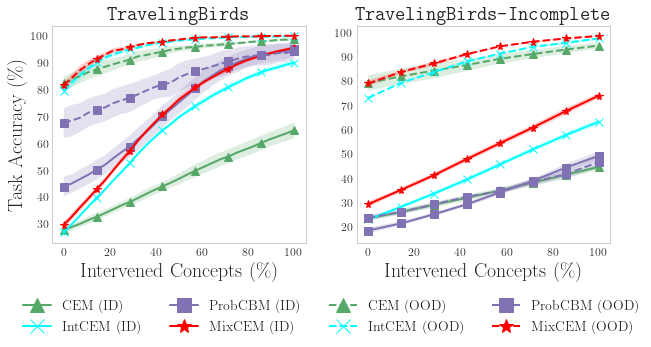

In [47]:
used_results_to_include = [
    x for x in used_results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    MAIN_METHOD,
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(5*len(used_results_to_include), 4))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (ID)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label.replace(" (ours)", "") + " (OOD)",
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened Concepts (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=20)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

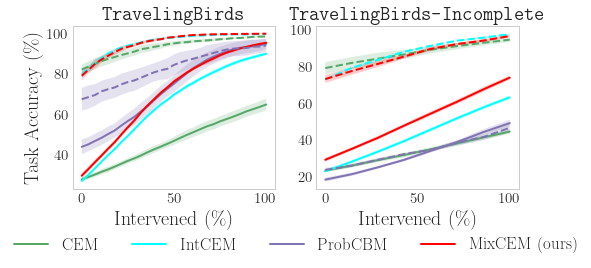

In [48]:
used_results_to_include = [
    x for x in used_results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    MAIN_METHOD,
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(4*len(used_results_to_include), 3))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']

    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # # Then make all the points
            # ax.plot(
            #     xticks[::4],
            #     means[::4],
            #     marker[-1:],
            #     color=color,
            #     label=label,
            #     markersize=8,
            # )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    used_select_metric = dataset_results.get(
        'select_metric',
        select_metric,
    )
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        if 'MixCEM' in label:
            # Then for the validation accuracy, we will use that of the
            # uncalibrated model, as otherwise it is not a fair comparison
            ints = np.array(get_metric_from_dict(
                results,
                selected_models.get(
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                ),
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        else:
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # # Then make all the points
            # ax.plot(
            #     xticks[::4],
            #     means[::4],
            #     marker[-1:],
            #     color=color,
            #     label=label,
            #     markersize=8,
            # )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_title(r'\texttt{' + dataset_results['name'] +'}', fontsize=20)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

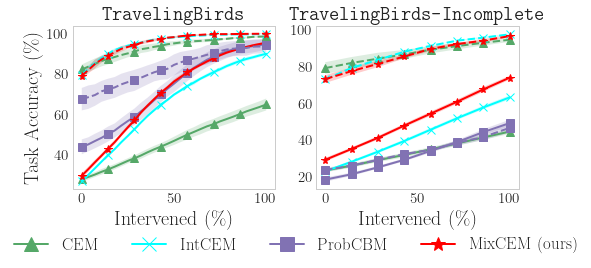

In [17]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "CEM",
    "IntCEM",
    "ProbCBM",
    MAIN_METHOD,
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(4*len(used_results_to_include), 3))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        if 'MixCEM' in label:
            # Then for the validation accuracy, we will use that of the
            # uncalibrated model, as otherwise it is not a fair comparison
            ints = np.array(get_metric_from_dict(
                results,
                selected_models.get(
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                ),
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        else:
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=20)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=4,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/spurious_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/spurious_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

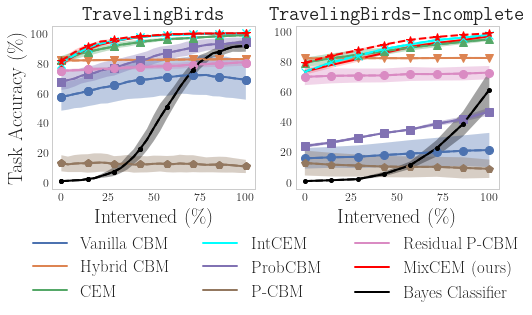

In [50]:
used_results_to_include = [
    x for x in used_results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
    "Bayes MLP",
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(4*len(used_results_to_include), 3))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']

    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        if 'MixCEM' in label:
            # Then for the validation accuracy, we will use that of the
            # uncalibrated model, as otherwise it is not a fair comparison
            ints = np.array(get_metric_from_dict(
                results,
                selected_models.get(
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                ),
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        else:
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=20)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=3,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem_complete{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_results_with_val_v2_true_mixcem_complete{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

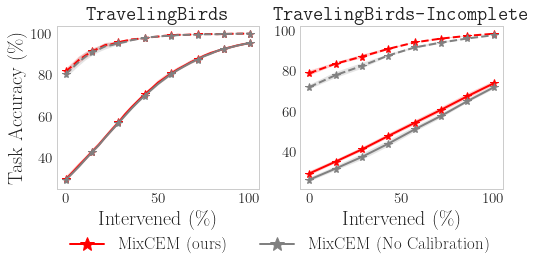

In [51]:
used_results_to_include = [
    x for x in used_results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    MAIN_METHOD,
    MAIN_METHOD.replace(" All", "").replace(" Sample", "") + " No Calibration",
    # "Bayes MLP",
]

fig, axs = plt.subplots(1, len(used_results_to_include), figsize=(4*len(used_results_to_include), 3))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '-' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )

for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        marker = '--' + marker[-1:]
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks,
                means,
                marker[:-1],
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker[-1:],
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=20)

    ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=20)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=17,
    loc='upper center',
    bbox_to_anchor=(-0.1,-0.2),
    ncol=3,
    markerscale=1.75,
)

plt.show()

### Combined Version for Appendix

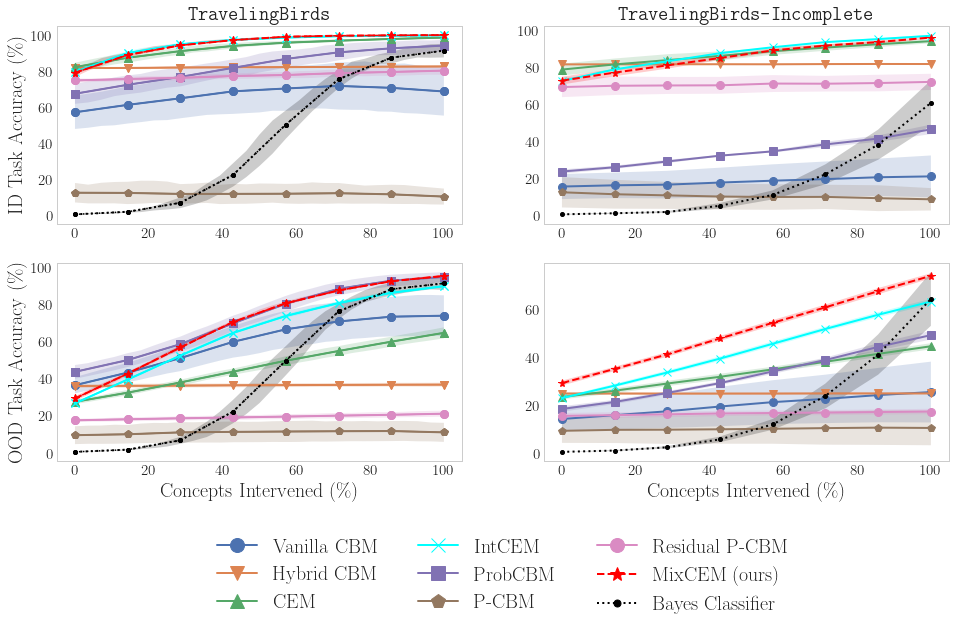

In [18]:
used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" in x['name']
]
used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Hybrid Posthoc CBM",
    MAIN_METHOD,
    "Bayes MLP",
]

fig, axs = plt.subplots(2, len(used_results_to_include), figsize=(8*len(used_results_to_include), 8))
for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[1, col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
        ax.set_xlabel("Concepts Intervened (\%)", fontsize=20)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        # ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=20)
        ax.grid(False)
        if col == 0:
            ax.set_ylabel("OOD Task Accuracy (\%)", fontsize=20)
    handles, labels = ax.get_legend_handles_labels()

for col, dataset_results in enumerate(used_results_to_include):
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']
    ax = axs[0, col]
    for idx, label in enumerate(used_baselines_to_include):
        mode_key = " (Baseline)"
        mode_name = "Baseline"
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + mode_key,
            label + mode_key,
        )
        if 'MixCEM' in label:
            # Then for the validation accuracy, we will use that of the
            # uncalibrated model, as otherwise it is not a fair comparison
            ints = np.array(get_metric_from_dict(
                results,
                selected_models.get(
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                    "Entropy CMCMixCEM No Calibration" + mode_key,
                ),
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        else:
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}val_acc_y_random_group_level_True_use_prior_False_ints",
            ))
        if len(ints) == 0:
            print("Skipping", model_name, "for", dataset_results['name'], "as we could not find any results...")
            continue
        label = used_rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "-x" if "Mix" in label else "-o")
        if dataset_results.get('intervention_freq', 1) != 1:
            freq = dataset_results.get('intervention_freq', 1)
            total_concepts = (len(means) - 1) * freq
            xticks = (
                [0] + list(100 * np.arange(1.0/total_concepts, 1, freq/total_concepts))
            )
        else:
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
        if len(means) > max_limit:
            # Then let's only plot half the points to avoid clutter
            # Make the line first
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
            # Then make all the points
            ax.plot(
                xticks[::4],
                means[::4],
                marker,
                color=color,
                label=label,
                markersize=8,
            )
        else:
            # Otherwise, plot all points
            ax.plot(
                xticks,
                means,
                marker,
                color=color,
                label=label,
                markersize=8,
                linewidth=2,
            )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(-5, 105)
    if col == 0:
        ax.set_ylabel("ID Task Accuracy (\%)", fontsize=20)

    # ax.set_xlabel("Intervened (\%)", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_title(r'\texttt{' + dataset_results['name'] + '}', fontsize=20)
    ax.grid(False)
ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(-0.1,-1.5),
    ncol=3,
    markerscale=1.75,
)

plt.savefig(f"../figures/spurious_complete_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/spurious_complete_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.savefig(f"../figures/paper/spurious_complete_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/paper/spurious_complete_results_with_val_v2_true_mixcem_with_points{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()

# Appendix Tabulations of Combined Results


In [62]:
from texttable import Texttable
import latextable
from collections import defaultdict

used_results_to_include = [
    x for x in results_to_include
    if "TravelingBirds" not in x['name']
]

# used_results_to_include = [
#     x for x in results_to_include
#     if "CUB" in x['name']
# ]
significance_check_method = "test"

used_baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Bayes MLP",
    "CEM",
    "IntCEM",
    MAIN_METHOD,
]

percents_to_include = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1,
]
cols = ["{}", "Method"] + [f'{int(100 * x)}\%' for x in percents_to_include] + ["AUC"]
rows = []
for dataset_idx, dataset_results in enumerate(used_results_to_include):
    latex_table = Texttable()
    results = dataset_results['results']
    selected_models = dataset_results['selected_models']

    col_results =  [defaultdict(list) for _ in range(2)]
    best_col_results = [defaultdict(lambda: (-float("inf"), None, None)) for _ in range(2)]
    for row, label in enumerate(used_baselines_to_include):
        label = dataset_results.get('rename', {}).get(label, label)
        model_name = selected_models.get(
            label + " (Baseline)",
            label + " (Baseline)",
        )
        new_row = []
        if row == 0:
            new_row = [
                r"{\parbox[t]{10mm}{\multirow{" +
                str(len(used_baselines_to_include)) +
                r"}{*}{\rotatebox{90}{\texttt{" +
                dataset_results['name'] +
                r"}}}}}"
            ]
        else:
            new_row = [r"{}"]
        metric_vals = []
        for col, percent_level in enumerate(percents_to_include):
            if percent_level == 0:
                equivalent_idx = 0
            else:
                sample_list = get_metric_from_dict(
                    results,
                    model_name,
                    f"test_acc_y_random_group_level_True_use_prior_False_ints",
                )
                equivalent_idx = int(np.ceil((len(sample_list[0]) - 1) * percent_level))
            metrics_to_include = [
                lambda x, y: np.array(get_metric_from_dict(
                    x,
                    y,
                    f"test_acc_y_random_group_level_True_use_prior_False_ints",
                ))[:, equivalent_idx] * 100,
                lambda x, y: np.array(get_metric_from_dict(
                    x,
                    y,
                    f"OOD_sap_0.1_test_acc_y_random_group_level_True_use_prior_False_ints",
                ))[:, equivalent_idx] * 100,
            ]
            used_name = used_rename_map.get(label, label)
            if len(new_row) == 1:
                new_row.append(used_name)
            for metric_idx, metric_fn in enumerate(metrics_to_include):
                metric_val = metric_fn(results, model_name)
                if len(metric_val) == 0:
                    raise ValueError(
                        f'Failed to get metric {metric_idx} for method {label} in "{dataset_results["name"]}"'
                    )
                mean = np.mean(metric_val, axis=0)
                std = np.std(metric_val, axis=0)
                if mean > best_col_results[metric_idx][col][0]:
                    best_col_results[metric_idx][col] = (mean, std, metric_val)
                col_results[metric_idx][col].append((mean, std, metric_val))

        # And add the AUC of the intervention curves
        col = len(percents_to_include)
        sample_list = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y_random_group_level_True_use_prior_False_ints",
        )
        n_ticks = int(np.ceil(dataset_results['n_groups'] / dataset_results.get('intervention_freq', 1)))
        metrics_to_include = [
            lambda x, y: np.sum(
                np.array(get_metric_from_dict(
                    x,
                    y,
                    f"test_acc_y_random_group_level_True_use_prior_False_ints",
                ))[:, 1:] * 1/(n_ticks),
                axis=0,
            ),
            lambda x, y: np.sum(
                np.array(get_metric_from_dict(
                    x,
                    y,
                    f"OOD_sap_0.1_test_acc_y_random_group_level_True_use_prior_False_ints",
                ))[:, 1:] * 1/(n_ticks),
                axis=-1,
            ),
        ]
        used_name = used_rename_map.get(label, label)
        for metric_idx, metric_fn in enumerate(metrics_to_include):
            metric_val = metric_fn(results, model_name)
            if len(metric_val) == 0:
                raise ValueError(
                    f'Failed to get metric {metric_idx} for method {label} in "{dataset_results["name"]}"'
                )
            mean = np.mean(metric_val, axis=0)
            std = np.std(metric_val, axis=0)
            if mean > best_col_results[metric_idx][col][0]:
                best_col_results[metric_idx][col] = (mean, std, metric_val)
            col_results[metric_idx][col].append((mean, std, metric_val))

        rows.append(new_row)

    for row, label in enumerate(used_baselines_to_include):
        new_row = rows[row + dataset_idx * len(used_baselines_to_include)]
        for col in range(len(percents_to_include) + 1):
            metrics_to_include = [
                'mediumblue',
                'mediumred',
            ]
            entry = '$'
            for metric_idx, color in enumerate(metrics_to_include):
                mean, std, vals = col_results[metric_idx][col][row]
                if metric_idx:
                    entry += " \; / \;"
                bolden = False
                if col == len(percents_to_include):
                    # Then we use a significance_check_method as this is different
                    # from plain accuracy
                    if (mean + num_stds * std >= (best_col_results[metric_idx][col][0] - num_stds * best_col_results[metric_idx][col][1])):
                        bolden = True
                elif significance_check_method == "confidence" and (
                    mean + num_stds * std >= (best_col_results[metric_idx][col][0] - num_stds * best_col_results[metric_idx][col][1])
                ):
                    bolden = True
                elif significance_check_method == "test" and (
                    not check_significance(best_col_results[metric_idx][col][2], vals)
                ):
                    bolden = True
                elif significance_check_method == "max" and (
                    best_col_results[metric_idx][col][0] == mean
                ):
                    bolden = True
                if bolden:
                    entry += (f" \\textcolor{{{color}}}{{\\mathbf{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
            new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
# print(latex_table.draw())
# print('\nLatextable Output:')
print("\n\n")
tab = latextable.draw_latex(
        latex_table,
        caption=(
            r"Task accuracy (\%) for ID  (\textcolor{mediumblue}{blue}) "
            r"and OOD (\textcolor{mediumred}{red}) samples as we "
            f"intervene on a larger fraction of randomly selected concept "
            f"groups. "
            r"These results show the same data as Figure~\ref{fig:concept_intervention_results} "
            f"but in a more accessible form. Each task's best result, and "
            f"those with overlapping 95\% confidence intervals, are in "
            r"\textbf{bold}."
        ),
        caption_above=True,
        label=f"tab:interventions",
        position="ht",
        use_booktabs=True,
)
tab = tab.replace(r'\begin{center}', r'\resizebox{\textwidth}{!}{' + "\n")
tab = tab.replace(r'\end{center}', "\n        " + "}")
tab = tab.replace(r'{\parbox', r'\hline{\parbox')
print(tab)





\begin{table}[ht]
	\caption{Task accuracy (\%) for ID  (\textcolor{mediumblue}{blue}) and OOD (\textcolor{mediumred}{red}) samples as we intervene on a larger fraction of randomly selected concept groups. These results show the same data as Figure~\ref{fig:concept_intervention_results} but in a more accessible form. Each task's best result, and those with overlapping 95\% confidence intervals, are in \textbf{bold}.}
	\resizebox{\textwidth}{!}{

		\begin{tabular}{ccccccccc}
			\toprule
			{} & Method & 0\% & 20\% & 40\% & 60\% & 80\% & 100\% & AUC \\
			\midrule
			\hline{\parbox[t]{10mm}{\multirow{9}{*}{\rotatebox{90}{\texttt{CUB}}}}} & Vanilla CBM & $ \textcolor{mediumblue}{70.97_{\pm 0.76}} \; / \; \textcolor{mediumred}{\mathbf{14.43_{\pm 1.16}}}$ & $ \textcolor{mediumblue}{80.43_{\pm 1.07}} \; / \; \textcolor{mediumred}{38.26_{\pm 2.93}}$ & $ \textcolor{mediumblue}{90.36_{\pm 1.56}} \; / \; \textcolor{mediumred}{77.55_{\pm 2.29}}$ & $ \textcolor{mediumblue}{\mathbf{95.36_{\pm 1.6

In [34]:
ood_suffix

'OOD_sap_0.5_'

In [156]:
len(rows)

18

# Sandbox

In [39]:
CONCEPT_SEMANTICS_SENTENCE_TEST = [
    "a bird with a dagger bill",
    "a bird with am all-purpose bill",
    "a bird with brown wings",
    "a bird with dark black wings",
    "a bird with white wings",
    "a brown bird",
    "a dark black bird",
    "a white bird",
]

IDXs = [
    1,
    6,
    10,
    20,
    21,
    249,
    259,
    260,
]


CONCEPT_SEMANTICS_NEGATION_TEST = [
    "a bird with a bill",
    "a bird with a bill",
    "bird wings",
    "bird wings",
    "bird wings",
    "a bird",
    "a bird",
    "a bird",
]

In [1]:
import os
import numpy as np
import pandas as pd

def attr_line_to_val(line):
    return int(line.split(" ")[2])

def get_sample_attributes(idx, lines):
    return np.array([
        attr_line_to_val(lines[x]) for x in range((idx - 1) * 312, idx * 312)
    ])
    
root_dir = "/anfs/bigdisc/me466/waterbirds"
cub_root_dir = "/homes/me466/data/CUB200/"
metadata_df = pd.read_csv(
    os.path.join(root_dir, 'metadata.csv')
)
image_true_idx = metadata_df['img_id'].values
with open(
    os.path.join(
        cub_root_dir,
        'CUB_200_2011/attributes/image_attribute_labels.txt',
    ),
    'r',
) as f:
    lines = [x.rstrip() for x in f]
attributes = np.array([
    get_sample_attributes(idx, lines) for idx in image_true_idx
])

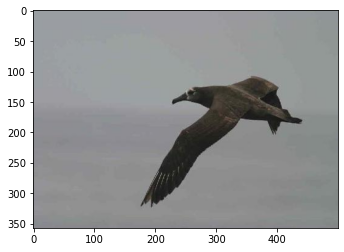

test_img_idx = 24
Processing 'blue wings' and 'wings without any blue' with similarities tensor([[0.8990]]) (between them), tensor([[0.2409]]) (pos emb), tensor([[0.2383]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.4474)
cosine similarity probs of correct label 0 = 0.43520424
Processing 'brown wings' and 'wings without any brown' with similarities tensor([[0.9139]]) (between them), tensor([[0.2669]]) (pos emb), tensor([[0.2432]]) (neg emb)
contrastive probs scale of correct label 1 = tensor(0.8744)
cosine similarity probs of correct label 1 = 0.91435295
Processing 'yellow wings' and 'wings without any yellow' with similarities tensor([[0.8826]]) (between them), tensor([[0.2224]]) (pos emb), tensor([[0.2376]]) (neg emb)
contrastive probs scale of correct label 0 = tensor(0.7730)
cosine similarity probs of correct label 0 = 0.8205849
Processing 'green wings' and 'wings without any green' with similarities tensor([[0.8679]]) (between them), tensor([[0.2405]]) (pos em

In [53]:
import torch
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from cem.data.cub_loader import CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
img_selected = "001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.jpg" #"027.Shiny_Cowbird/Shiny_Cowbird_0007_24434.jpg"
im = Image.open(f"/homes/me466/data/CUB200/CUB_200_2011/images/{img_selected}")
plt.imshow(im)
plt.show()
test_img = preprocess(im).unsqueeze(0).to(device)
with open('/homes/me466/data/CUB200/CUB_200_2011/images.txt', 'r') as f:
    img_names = [x.rstrip().split(" ")[-1] for x in f]
test_img_idx = img_names.index(img_selected)
print("test_img_idx =", test_img_idx)
test_img_emb = model.encode_image(test_img)
test_img_emb = test_img_emb / test_img_emb.norm(dim=1, keepdim=True)
test_img_attrs = attributes[test_img_idx, :]
embeddings = []
with torch.no_grad():
    for idx, (pos_descr, neg_descr) in enumerate(zip(CONCEPT_SEMANTICS_SENTENCE, CONCEPT_SEMANTICS_NEGATION)):
        # idx = IDXs[idx]
        pos_text = clip.tokenize([pos_descr]).to(device)
        pos_emb = model.encode_text(pos_text)
        pos_emb = pos_emb / pos_emb.norm(dim=1, keepdim=True)
        neg_text = clip.tokenize([neg_descr]).to(device)
        neg_emb = model.encode_text(neg_text)
        neg_emb = neg_emb / neg_emb.norm(dim=1, keepdim=True)

        score_pos = (pos_emb - test_img_emb).pow(2).sum(-1).sqrt()
        score_neg = (neg_emb - test_img_emb).pow(2).sum(-1).sqrt()
        # probs = torch.sigmoid(
        #     score_neg - score_pos
        # )
        # probs = [1-probs, probs]
        # print("contrastive probs =", probs)
        
        cont_probs = torch.sigmoid(
            100 * (score_neg - score_pos)
        )
        cont_probs = [1-cont_probs, cont_probs]

        score_pos = pos_emb @ test_img_emb.t()
        score_neg = neg_emb @ test_img_emb.t()
        cos_probs = (model.logit_scale.exp() * torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0).cpu().numpy()
        print(f"Processing '{pos_descr}' and '{neg_descr}' with similarities {pos_emb @ neg_emb.t()} (between them), {score_pos} (pos emb), {score_neg} (neg emb)")
        print(f"contrastive probs scale of correct label {test_img_attrs[idx]} =", cont_probs[test_img_attrs[idx]][0])
        print(f"cosine similarity probs of correct label {test_img_attrs[idx]} =", cos_probs[test_img_attrs[idx], 0])
        # probs = (torch.concat([score_neg, score_pos], dim=0)).softmax(dim=0)
        # print("cosine similarity probs no scale =", probs)
        
        embeddings.append((pos_emb, neg_emb))
embs = np.array([
    np.concatenate(x, axis=0)
    for x in embeddings
])

In [37]:
with open('../cub_ViT-B_32_concept_embeddings.npy', 'wb') as f:
    np.save(f, embs)

In [51]:
import torch
import clip
from PIL import Image

device = 'cpu'
model, preprocess = clip.load("ViT-B/32", device=device)
if not os.path.exists('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings'):
    os.makedirs('/homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings')
count = 0
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        count += 1

current_count = 0
batch_size = 512
current_batch = []
for subdir, dirs, files in os.walk('/homes/me466/data/CUB200/CUB_200_2011/images/'):
    for file in files:
        if not file.endswith(".jpg"):
            continue
        image_filename = os.path.join(subdir, file)
        dirname = os.path.dirname(image_filename)
        emb_directory = dirname.replace('/images/', '/clip_ViT-B_32_embeddings/')
        if not os.path.exists(emb_directory):
            os.makedirs(emb_directory)

        emb_filename = os.path.join(emb_directory, file.replace('jpg', 'npy'))
        image = preprocess(Image.open(image_filename)).unsqueeze(0).to(device)
        current_batch.append((image, emb_filename))
        if len(current_batch) == batch_size:
            print("Flushing the batch!")
            # Then time to fush the batch!
            with torch.no_grad():
                batch_of_images = torch.cat([x[0] for x in current_batch], axis=0)
                image_features = model.encode_image(batch_of_images)
                for idx, (_, current_file_name) in enumerate(current_batch):
                    print(f"\tSaving image {idx + 1}/{batch_size}")
                    with open(current_file_name, 'wb') as f:
                        np.save(f, image_features[idx, :])
            current_batch = []
        print(f"[{100 * current_count/count:.2f}%] Saving embedding for", image_filename, "to", emb_filename)
        current_count += 1


[0.00%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0001_794941.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0001_794941.npy
[0.01%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0029_1824.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0029_1824.npy
[0.02%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0074_794949.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0074_794949.npy
[0.03%] Saving embedding for /homes/me466/data/CUB200/CUB_200_2011/images/005.Crested_Auklet/Crested_Auklet_0045_794940.jpg to /homes/me466/data/CUB200/CUB_200_2011/clip_ViT-B_32_embeddings/005.Crested_Auklet/Crested_Auklet_0045_794940.npy
[0.03%] Saving embedding for /homes/me466/da

KeyboardInterrupt: 